<a href="https://colab.research.google.com/github/thanhtruchhh/Quantium-Virtual-Internship-Retail-Strategy-and-Analytics/blob/main/Task_2_Experimentation_and_uplift_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task overview
You are part of Quantium’s retail analytics team and have been approached by your client. The Category Manager for Chips - Julia, has asked us to test the impact of the new trial layouts with a data driven recommendation to whether or not the trial layout should be rolled out to all their stores.

Julia has asked us to evaluate the performance of a store trial which was performed in stores 77, 86 and 88. Trial period was from the start of Feb-2019 to the end of Apr-2019.

To get started, use the output from task 1 and consider the monthly sales experience of each store. Only consider stores have sales every month over July 2018 to June 2019.


# Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_ind, t
import seaborn as sns
from statistics import stdev

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
url = '/content/drive/MyDrive/Dataset/Quantium_Retail Strategy and Analytics/Task 2/QVI_data.csv'

In [4]:
df = pd.read_csv(url)
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [5]:
df.isnull().sum()

LYLTY_CARD_NBR      0
DATE                0
STORE_NBR           0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [7]:
# Covert DATE to datetime
df['DATE'] = pd.to_datetime(df['DATE'])
df['DATE'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 264834 entries, 0 to 264833
Series name: DATE
Non-Null Count   Dtype         
--------------   -----         
264834 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.0 MB


# Select control stores
Select control stores: Identify control stores that have similar pre-trial performance metrics to the trial stores.

The client has selected store numbers 77, 86, and 88 as trial stores and want
control stores to be established stores that are operational for the entire observation period.

We would want to match trial stores to control stores that are similar to the trial store prior to the trial period of Feb 2019 in terms of:
* Monthly overall sales revenue
* Monthly number of customers
* Monthly number of transactions per customer

## Calculate metrics
Calculate the following metrics for each store and month:
  * Total sales revenue
  * Total number of customers
  * Average number of transactions per customer
  * Chips per customer
  * Average price per unit

In [8]:
# Add a new month ID column with the format yyyymm
df['YEARMONTH'] = df['DATE'].dt.strftime('%Y%m').astype('int')
df[['DATE', 'YEARMONTH']].head()

,DATE,YEARMONTH
0,2018-10-17,201810
1,2018-09-16,201809
2,2019-03-07,201903
3,2019-03-08,201903
4,2018-11-02,201811


In [9]:
# For each store and month calculate total sales, number of customers, transactions per customer, chips per customer and the average price per unit
measures_over_time = df.groupby(by = ['STORE_NBR', 'YEARMONTH']).agg({
  'TOT_SALES': 'sum', # Total sales
  'LYLTY_CARD_NBR': 'nunique', # Number of customers
  'TXN_ID': 'nunique', # Number of transactions
  'PROD_QTY': 'sum' # Number of chips
}).reset_index()

measures_over_time.columns = ['STORE_NBR', 'YEARMONTH', 'tot_sales', '#customers', '#txns', '#chips']

measures_over_time['#txns_per_cust'] = measures_over_time['#txns'] / measures_over_time['#customers'] # Transactions per customer
measures_over_time['#chips_per_txn'] = measures_over_time['#chips'] / measures_over_time['#txns'] # Chips per customer
measures_over_time['avg_price_per_unit'] = measures_over_time['tot_sales'] / measures_over_time['#chips'] # Average price per unit

# Remove unuseful cols
measures_over_time.drop(['#txns', '#chips'], axis = 1, inplace = True)

measures_over_time

,STORE_NBR,YEARMONTH,tot_sales,#customers,#txns_per_cust,#chips_per_txn,avg_price_per_unit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947
...,...,...,...,...,...,...,...
3164,272,201902,395.5,45,1.066667,1.895833,4.346154
3165,272,201903,442.3,50,1.060000,1.905660,4.379208
3166,272,201904,445.1,54,1.018519,1.909091,4.239048
3167,272,201905,314.6,34,1.176471,1.775000,4.430986


In [10]:
measures_over_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   STORE_NBR           3169 non-null   int64  
 1   YEARMONTH           3169 non-null   int64  
 2   tot_sales           3169 non-null   float64
 3   #customers          3169 non-null   int64  
 4   #txns_per_cust      3169 non-null   float64
 5   #chips_per_txn      3169 non-null   float64
 6   avg_price_per_unit  3169 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 173.4 KB


## Filter pre-trial data
Filter the data to only include the pre-trial period and stores with full observation periods.

In [11]:
# Filter to the pre-trial period and stores with full observation periods
# Filter only stores with full 12 months observation
full_obs = 12
obs_count = (measures_over_time['STORE_NBR'].value_counts()).to_frame().reset_index()
stores_with_full_obs = obs_count[obs_count['count'] == full_obs]['STORE_NBR']

# Filter free-trial stores
start_trial_period = 201902
pre_trial_full_obs_measures = measures_over_time[(measures_over_time['STORE_NBR'].isin(stores_with_full_obs)) & (measures_over_time['YEARMONTH'] < start_trial_period)]

pre_trial_full_obs_measures.head()

,STORE_NBR,YEARMONTH,tot_sales,#customers,#txns_per_cust,#chips_per_txn,avg_price_per_unit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947


In [12]:
pre_trial_full_obs_measures.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1820 entries, 0 to 3163
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   STORE_NBR           1820 non-null   int64  
 1   YEARMONTH           1820 non-null   int64  
 2   tot_sales           1820 non-null   float64
 3   #customers          1820 non-null   int64  
 4   #txns_per_cust      1820 non-null   float64
 5   #chips_per_txn      1820 non-null   float64
 6   avg_price_per_unit  1820 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 113.8 KB


## Find control stores
1. Calculate the Pearson correlation between the trial store's metrics and each control store's metrics.
2. Calculate the magnitude distance between the trial store's performance and each potential control store &rarr; Standardize the magnitude distance so that the measure ranges from 0 to 1.
3. Composite correlation score and standardized distance score of each key metric basing on weight.
4. Combine composite scores of all key metrics by calculate average.
5. Figure out control stores which have highest combine composite scores.

Trial stores: 77, 86 and 88

In [13]:
trial_stores = [77, 86, 88]

**Calculate the Pearson correlation:**

Calculate the correlation coefficient to evalute the linear correlation between two stores.
* Correlation coefficient > 0: The two stores have very similar trend and patterns.
* Correlation coefficient < 0: The two stores have very similar trend and patterns, but in the opposite directions.
* Correlation coefficient = 0: The two stores completely not correlated at all. There is no relationship between the two stores.

In [14]:
# Function to calculate Pearson correlation
def calc_correlation(input_table, metric_col, store_comparison):
  trial_store_data = input_table[input_table['STORE_NBR'] == store_comparison]
  correlations = {}

  for store in input_table['STORE_NBR'].unique():
    if store not in trial_stores: # Exclude trial stores
      control_store_data = input_table[input_table['STORE_NBR'] == store]
      corr, _ = pearsonr(trial_store_data[metric_col], control_store_data[metric_col])
      correlations[store] = corr

  return correlations

**Calculate the magnitude distance:**

Calculate the difference in key metrics between two stores:
* A higher difference indicates values of a metric of two stores are quite different.
* A lower difference indicates values of a metric of two stores are quite close.

*(Note: need to normalize the differences in order to enable the differences to be used to measure the similarity along with the correlation coefficient)*

In [15]:
# Function to calculate magnitude distance
# Need to normalize the differences in order to enable the differences to be used to measure the similarity along with the correlation coefficient
def calc_magnitude_distance(input_table, metric_col, store_comparison):
  trial_store_data = input_table[input_table['STORE_NBR'] == store_comparison]
  magnitudes = {}

  for store in input_table['STORE_NBR'].unique():
    if store not in trial_stores: # Exclude trial stores
      control_store_data = input_table[input_table['STORE_NBR'] == store]
      diff = np.abs(trial_store_data[metric_col].values - control_store_data[metric_col].values)
      magnitude = np.sum(diff)
      magnitudes[store] = magnitude

  # Standardize the magnitude distances so that the measure ranges from 0 to 1
  min_magnitude = min(magnitudes.values())
  max_magnitude = max(magnitudes.values())
  standardized_magnitudes = {store: 1 - (magnitudes[store] - min_magnitude) / (max_magnitude - min_magnitude)
                              for store in magnitudes}

  return standardized_magnitudes

**Composite scores:**

Calculate composite scores of each key metric, following the below formulas:

  `Composite score = Corr_weight * Correlation + (1 - Corr_weight) * Distance`

*(By default, corr_weight = .5 &rarr; Calculate composite scores by averaging correlation and standardized magnitude distance scores.)*


In [16]:
# Function to calculate composite score basing on correlative score and standardized distances
def calc_composite_score(correlations, standardized_distances, corr_weight = 0.5):
  composite_scores = {}
  for store in correlations.keys():
      composite_score = corr_weight * correlations[store] + (1 - corr_weight) * standardized_distances[store]
      composite_scores[store] = composite_score
  return composite_scores

**Calculate final scores of all key metrics:**

Cobine composite scores of key metrics by calcualte average.

In [17]:
# Function to combine the composite scores
def calculate_combined_composite_score(*composite_scores_dicts):
  combined_scores = {}
  num_metrics = len(composite_scores_dicts)

  # Get all unique stores
  all_stores = set()
  for score_dict in composite_scores_dicts:
      all_stores.update(score_dict.keys())

  # Calculate the average composite score for each store
  for store in all_stores:
      total_score = 0
      count = 0
      for score_dict in composite_scores_dicts:
          if store in score_dict:
              total_score += score_dict[store]
              count += 1
      if count > 0:
          combined_scores[store] = total_score / count

  return combined_scores

Selecting control stores is based on how similar key metrics are to the trial stores.

Key metrics to compare two stores:
* tot_sales
* #customers

In [18]:
key_metrics = ['tot_sales', '#customers']

**Find control stores:**

Rank the control stores for the trial store &rarr; The store with the highest score is then selected as the control store.

In [19]:
# Function to sort combine composition scores desc
def rank_combined_scores(combined_scores):
  return sorted(combined_scores.items(), key = lambda x: x[1], reverse = True)

Let's find out which store is the control store of the trial stores.

In [20]:
# Function to figure out a corresponding control store for the trial store
def find_control_store(input_table, trial_store):
  # Calculate correlation
  tot_sales_corr = calc_correlation(input_table, key_metrics[0], trial_store)
  num_customers_corr = calc_correlation(input_table, key_metrics[1], trial_store)

  # Calculate magnitude distance
  tot_sales_diff = calc_magnitude_distance(input_table, key_metrics[0], trial_store)
  num_customers_diff = calc_magnitude_distance(input_table, key_metrics[1], trial_store)

  # Calculate composite scores
  composite_score_tot_sales = calc_composite_score(tot_sales_corr, tot_sales_diff)
  composite_score_num_customers = calc_composite_score(num_customers_corr, num_customers_diff)

  # Calculate combined composite scores
  combined_composite_scores = calculate_combined_composite_score(composite_score_tot_sales, composite_score_num_customers)

  # Rank potential control stores
  ranked_control_stores = rank_combined_scores(combined_composite_scores)

  # Select the store with the highest final score
  control_store = ranked_control_stores[0][0]

  return control_store


In [21]:
control_stores = []

# Figure out control stores
for trial_store in trial_stores:
  # Add found control store into the array
  control_stores.append(find_control_store(pre_trial_full_obs_measures, trial_store))

In [22]:
# Create a dict from trial_stores and control_stores
trial_control_stores = dict(zip(trial_stores, control_stores))
trial_control_stores

{77: 233, 86: 155, 88: 237}

In [24]:
# Function to get the responding control store
def get_control_store(trial_store):
  return trial_control_stores[trial_store]

# Check selected control stores again
Check visually if the the control stores are indeed similar in the period before the trial.

1. Calculate key metrics in the pre-trial period *(before Feb 2019)* by store types, including:
  * Trial.
  * Control.
  * Others.
2. Visualize each key metric by time and store types.

In [27]:
# Function to format a int value (eg: 201901) to a string value with YYYY-MM format (eg: 2019-01)
def format_yyyy_mm_val(val):
  years = str(val)[:4]
  months = str(val)[4:]
  return years + '-' + months

# Function to format a int column (eg: 201901) to a string column with YYYY-MM format (eg: 2019-01)
def format_yyyy_mm_col(col):
  return col.apply(format_yyyy_mm_val)

In [28]:
# Function to calculate key metric for trial store, control store, and average key metric for others by time
def calc_key_metric_by_time_store_type(df, trial_store, key_metric_col, store_col = 'STORE_NBR', time_col = 'YEARMONTH'):
  control_store = get_control_store(trial_store)

  # Timely key metric for trial store, control store, others
  pre_trial_trial_store = df[df[store_col] == trial_store][[time_col, key_metric_col]].set_index(time_col)
  pre_trial_control_store = df[df[store_col] == control_store][[time_col, key_metric_col]].set_index(time_col)

  # If calc for other stores, use avg value
  pre_trial_other_store = df[~df[store_col].isin([trial_store, control_store])].groupby(time_col)[key_metric_col].mean()

  # Merge timely key metric into a df
  pre_trial = pd.concat([pre_trial_trial_store, pre_trial_control_store, pre_trial_other_store], axis = 1).reset_index()

  # Rename columns
  pre_trial.columns = [time_col, f'trial_store_{trial_store}', f'control_store_{control_store}', 'other_store']

  # Convert time col to string with YYYY-MM format
  pre_trial[time_col] = format_yyyy_mm_col(pre_trial[time_col])

  # Sort by time
  pre_trial.sort_values(by = time_col, inplace = True)

  return pre_trial

In [29]:
# Viz line chart by time and store type
def viz_key_metric_by_time_store_type(df, key_metric, y_label, time_col = 'YEARMONTH'):
  # Melt the DataFrame to reshape for the line chart
  var_col = 'store_type'
  melted_df = df.melt(id_vars = time_col, var_name = var_col, value_name = key_metric)

  fig, ax = plt.subplots(figsize=(20, 5))

  sns.lineplot(data = melted_df, x = time_col, y = key_metric, hue = var_col)

  ax.set_ylabel(y_label)
  ax.set_xlabel('Time')
  ax.set_title(f'{y_label} by Time and Store type', fontsize = 14)

  sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)) # Move legend

## Store 77

### Total sales

In [30]:
pre_trial_tot_sales_77 = calc_key_metric_by_time_store_type(pre_trial_full_obs_measures, 77, 'tot_sales')

pre_trial_tot_sales_77

,YEARMONTH,trial_store_77,control_store_233,other_store
0,2018-07,296.8,290.7,638.004651
1,2018-08,255.5,285.9,610.223450
2,2018-09,225.2,228.6,620.198450
3,2018-10,204.5,185.7,635.314729
4,2018-11,245.3,211.6,618.864341
5,2018-12,267.3,279.8,648.453876
6,2019-01,204.4,177.5,628.684496


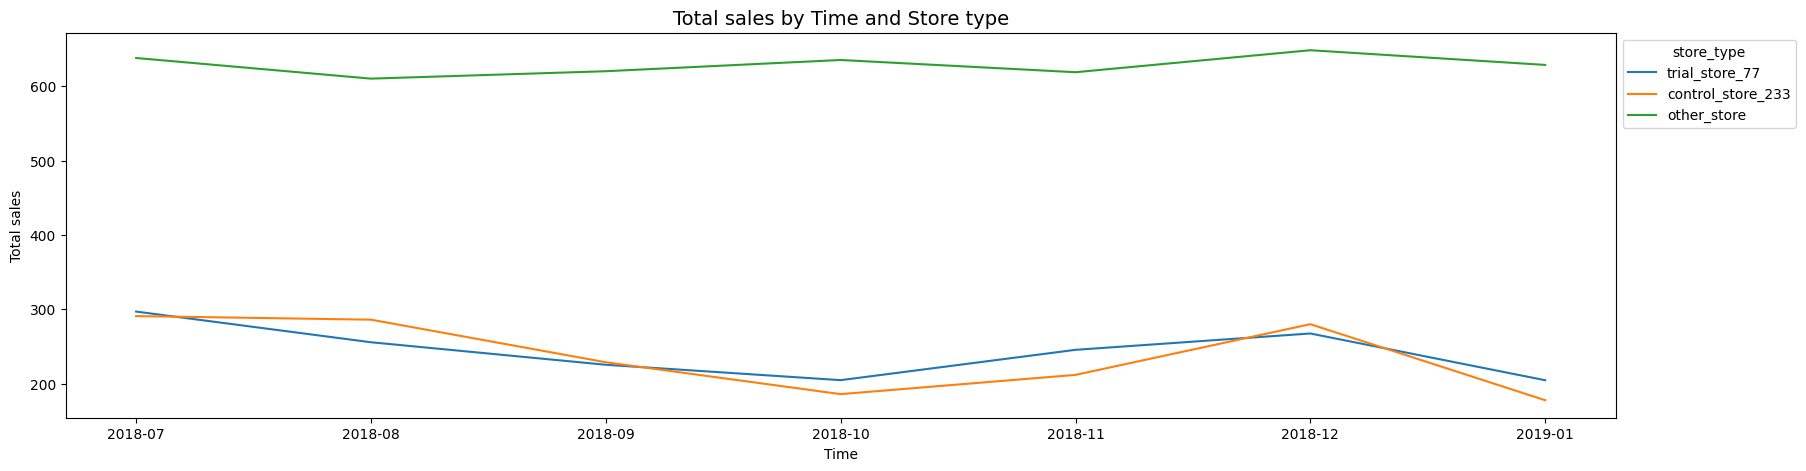

In [31]:
viz_key_metric_by_time_store_type(pre_trial_tot_sales_77, 'tot_sales', 'Total sales')

### No of customers

In [32]:
pre_trial_num_customers_77 = calc_key_metric_by_time_store_type(pre_trial_full_obs_measures, 77, '#customers')

pre_trial_num_customers_77

,YEARMONTH,trial_store_77,control_store_233,other_store
0,2018-07,51,51,72.333333
1,2018-08,47,48,72.120155
2,2018-09,42,42,70.131783
3,2018-10,37,35,71.608527
4,2018-11,41,40,70.534884
5,2018-12,46,47,73.515504
6,2019-01,35,35,71.240310


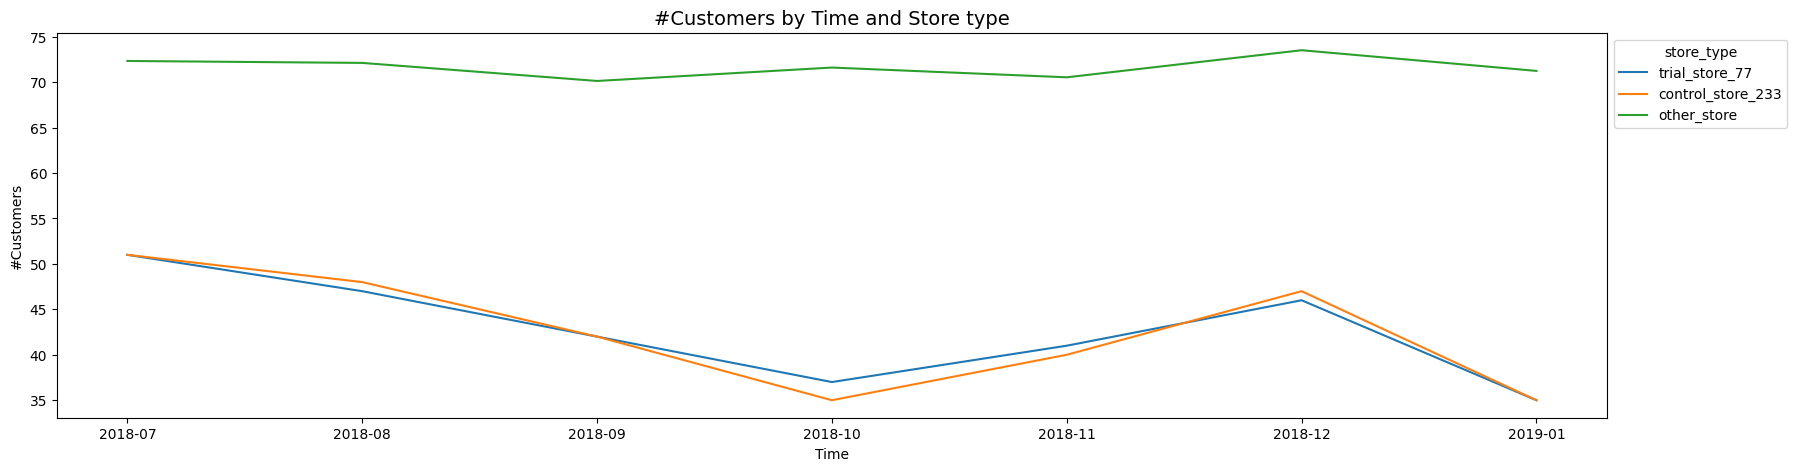

In [33]:
viz_key_metric_by_time_store_type(pre_trial_num_customers_77, '#customers', '#Customers')

## Store 86

### Total sales

In [34]:
pre_trial_tot_sales_86 = calc_key_metric_by_time_store_type(pre_trial_full_obs_measures, 86, 'tot_sales')

pre_trial_tot_sales_86

,YEARMONTH,trial_store_86,control_store_155,other_store
0,2018-07,892.20,924.6,633.239922
1,2018-08,764.05,782.7,606.326744
2,2018-09,914.60,1014.4,614.480620
3,2018-10,948.40,963.8,629.415504
4,2018-11,918.00,898.8,613.593411
5,2018-12,841.20,849.8,644.020155
6,2019-01,841.40,874.6,623.513566


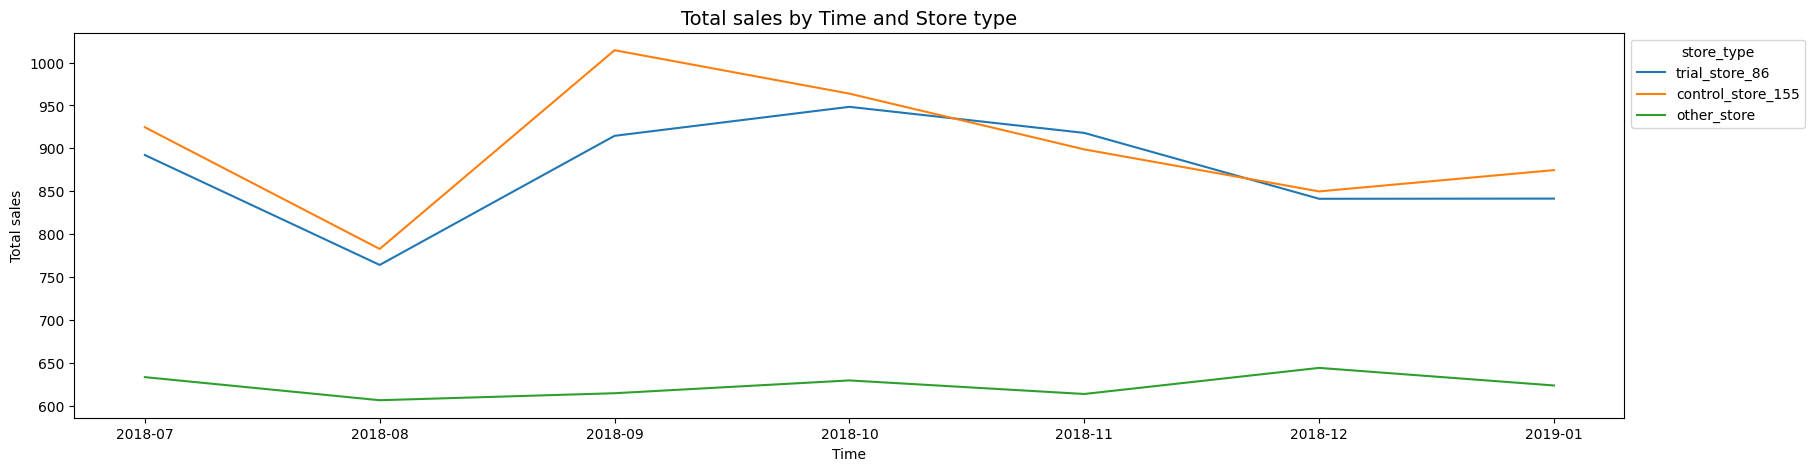

In [35]:
viz_key_metric_by_time_store_type(pre_trial_tot_sales_86, 'tot_sales', 'Total sales')

### No of customers

In [36]:
pre_trial_num_customers_86 = calc_key_metric_by_time_store_type(pre_trial_full_obs_measures, 86, '#customers')

pre_trial_num_customers_86

,YEARMONTH,trial_store_86,control_store_155,other_store
0,2018-07,99,101,71.953488
1,2018-08,94,91,71.771318
2,2018-09,103,103,69.658915
3,2018-10,109,108,71.046512
4,2018-11,100,101,70.069767
5,2018-12,98,97,73.120155
6,2019-01,94,96,70.775194


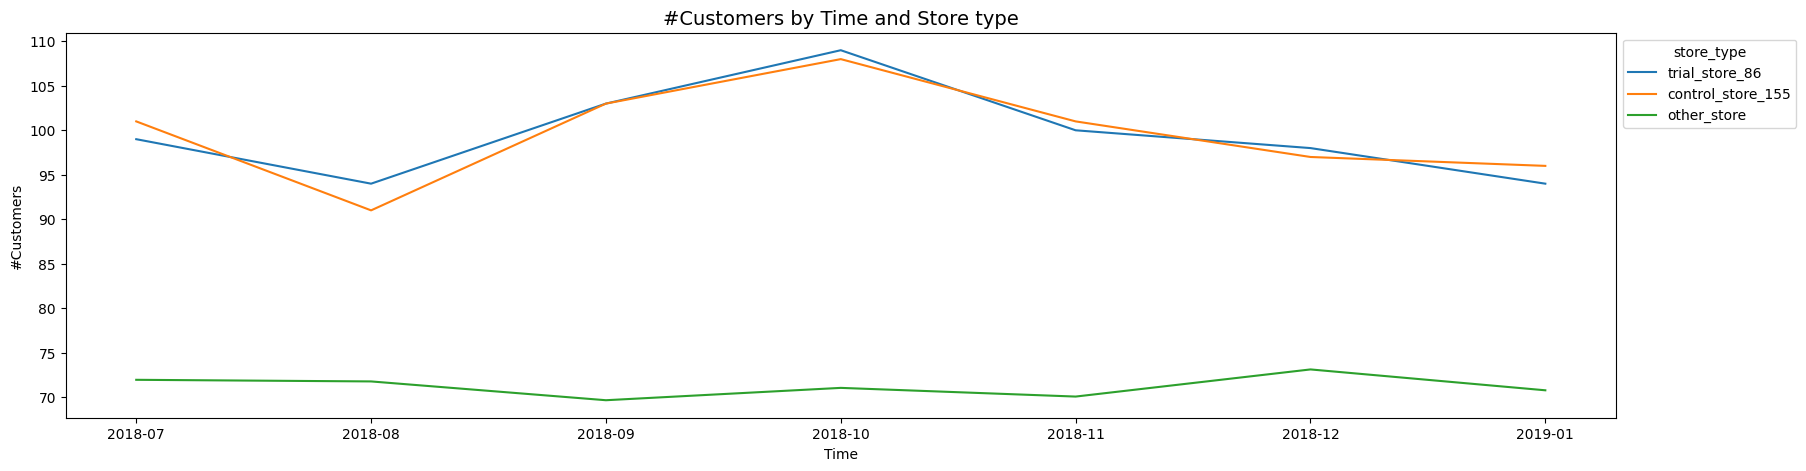

In [37]:
viz_key_metric_by_time_store_type(pre_trial_num_customers_86, '#customers', '#Customers')

## Store 88

### Total sales

In [38]:
pre_trial_tot_sales_88 = calc_key_metric_by_time_store_type(pre_trial_full_obs_measures, 88, 'tot_sales')

pre_trial_tot_sales_88

,YEARMONTH,trial_store_88,control_store_237,other_store
0,2018-07,1310.0,1448.4,629.590310
1,2018-08,1323.8,1367.8,601.889341
2,2018-09,1423.0,1322.2,611.317054
3,2018-10,1352.4,1348.3,626.359302
4,2018-11,1382.8,1397.6,609.858527
5,2018-12,1325.2,1265.0,640.534884
6,2019-01,1266.4,1219.7,620.528682


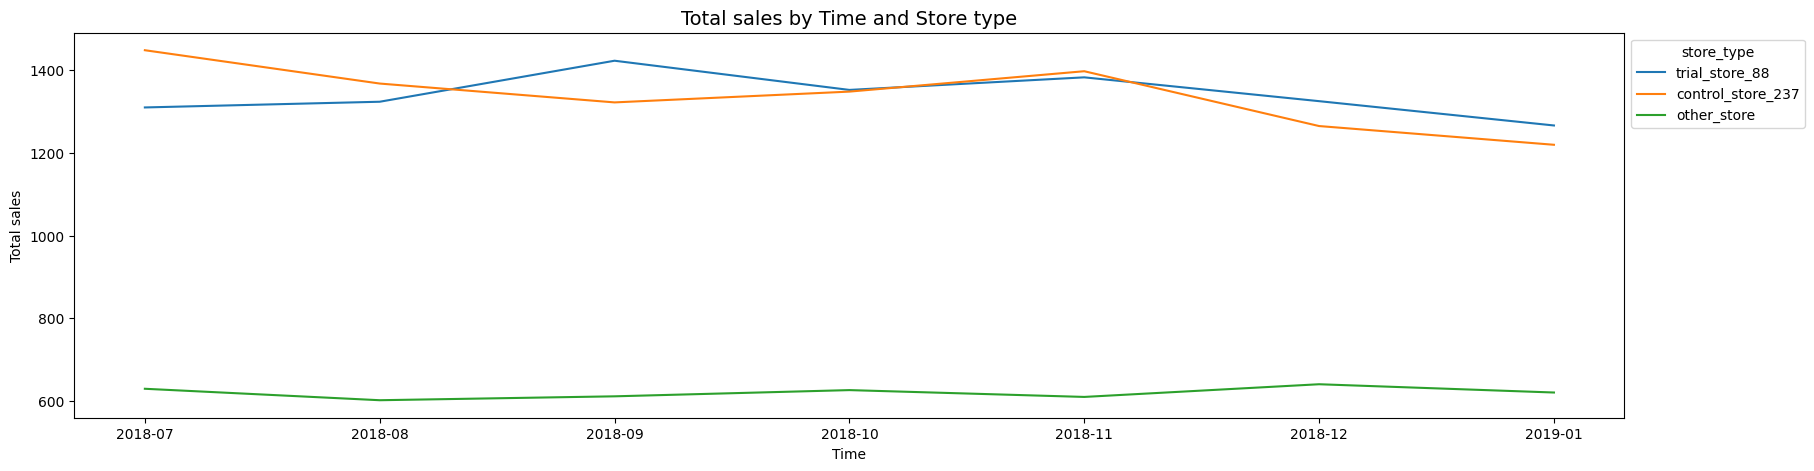

In [40]:
viz_key_metric_by_time_store_type(pre_trial_tot_sales_88, 'tot_sales', 'Total sales')

### No of customers

In [39]:
pre_trial_num_customers_88 = calc_key_metric_by_time_store_type(pre_trial_full_obs_measures, 88, '#customers')

pre_trial_num_customers_88

,YEARMONTH,trial_store_88,control_store_237,other_store
0,2018-07,129,128,71.732558
1,2018-08,131,135,71.457364
2,2018-09,124,126,69.488372
3,2018-10,123,123,70.934109
4,2018-11,130,132,69.833333
5,2018-12,126,124,72.906977
6,2019-01,117,117,70.604651


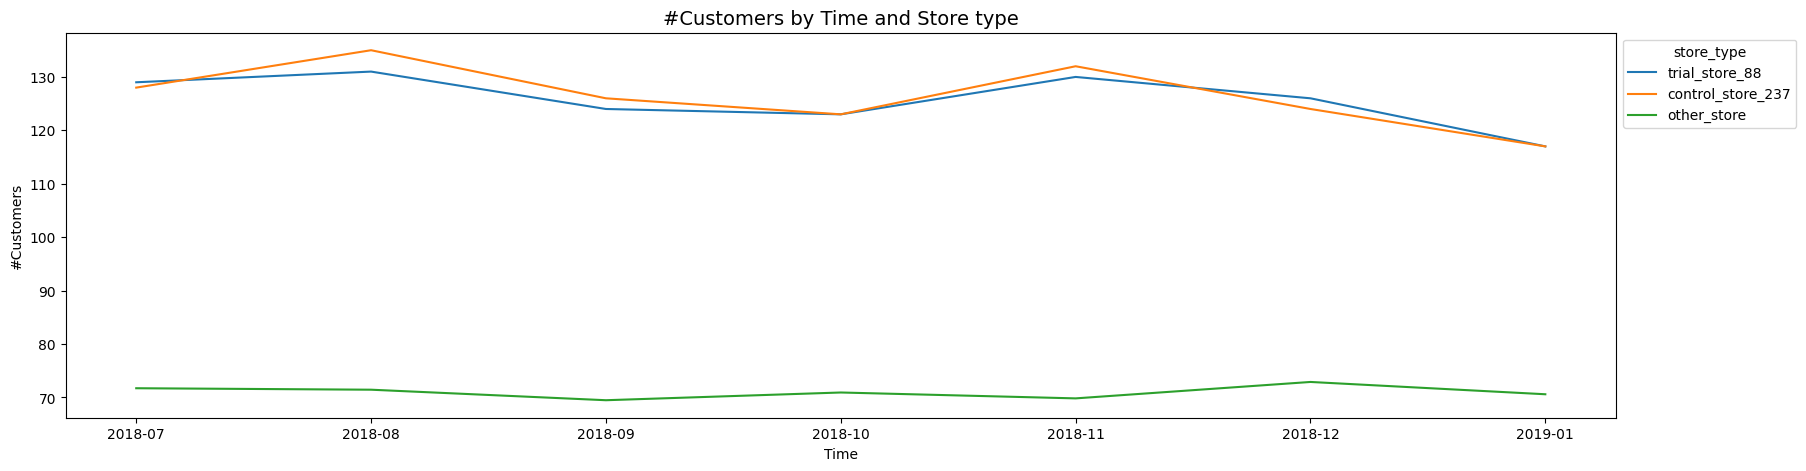

In [41]:
viz_key_metric_by_time_store_type(pre_trial_num_customers_88, '#customers', '#Customers')

Trial-control store pairs have quite similar total sales and numbers of customers.

# Assess trial
The trial period goes from the start of February 2019 to April 2019. We now want to see if there has been an uplift in overall chip key metric performance basing on changes of key metrics.
1. Scale the key metric of the control store to match the pre-trial key metric of the trial store. This helps in normalizing any inherent differences between the trial and control stores during pre-trial period.
2. Calculate the percentage difference between the scaled control key metric and the trial store's key metric.
3. Test the hypothesis that there is no significant difference between the trial period and the pre-trial period:
  * Calculate t-values for the trial months.
  * Check if the observed differences are statistically significant.

In [42]:
end_trial_period = 201904

There are key metrics choosen:
* tot_sales
* #customers

In [43]:
print(key_metrics)

['tot_sales', '#customers']


**Scale control store key metric:**

Scaling is necessary to account for inherent differences in key metric levels between the trial and control stores that existed before the trial period. These differences could arise due to various factors such as location, customer base, store size, and other operational characteristics. If we don't account for these differences, any comparison during the trial period might be biased and not accurately reflect the impact of the trial intervention.

How to scale:
1. Calculate pre-trial key metric of both trial and control stores.
2. Determine the scaling factor, which adjusts the control store’s key metric to be on the same scale as the trial store's key metric, following the below formulas:
  
  `Scaling factor = Trial store pre-trial key metric​ / Control store pre-trial key metric​`
3. Apply this scaling factor to the control store's key metric, following the below formulas:

  `Scaled control store trial key metric = Control store trial key metric * Scaling factor`

In [44]:
# Create a deep copy of measures_over_time, any changes on scaled_measures_over_time will not affect measures_over_time
scaled_measures_over_time = measures_over_time.copy()

In [45]:
# Function to scale control store key metric
def scale_control_key_metric(df, scaled_df, trial_store, key_metric, start_trial_period):
  # Find the corresponding control store
  control_store = get_control_store(trial_store)

  # Filter records of control store
  control_key_metric = df[(df['STORE_NBR'] == control_store)]

  # Calculate total pre-trial key metric for trial and control stores
  trial_pre_trial_key_metric = df[(df['STORE_NBR'] == trial_store) & (df['YEARMONTH'] < start_trial_period)][key_metric].sum()
  control_pre_trial_key_metric = control_key_metric[control_key_metric['YEARMONTH'] < start_trial_period][key_metric].sum()

  # Calculate the scaling factor
  scaling_factor = trial_pre_trial_key_metric / control_pre_trial_key_metric

  # Apply the scaling factor to control store key metric in the scaled df
  scaled_df.loc[scaled_df['STORE_NBR'] == control_store, key_metric] *= scaling_factor

In [46]:
#  Scale pre-trial control total sales, #customers to match pre-trial trial store total sales, #customers
for trial_store in trial_stores:
  for key_metric in key_metrics:
    scale_control_key_metric(measures_over_time, scaled_measures_over_time, trial_store, key_metric, start_trial_period)

**Calculating percentage differences:**

Calculate the percentage differences between the scaled control key metric and trial key metric, following the below formulas:

  `%Diff = |Trial store trial key metric​ - Control store trial key metric| / Trial store trial key metric`

When calculating percentage difference, remember to use absolute
difference &rarr; Simplify comparisons and computations, ensuring clarity and efficiency in assessing differences between data points.

In [47]:
# Function to calc %diff between control and trial stores' key metric during the trial period
def calc_percentage_difference(df, trial_store, key_metric):
  # Find the corresponding control store
  control_store = get_control_store(trial_store)

  # Calculate total pre-trial key metric for trial and control stores
  trial_store_df = df[df['STORE_NBR'] == trial_store][['YEARMONTH', key_metric]].rename(columns = {key_metric : f'trial_store_{trial_store}'})
  control_store_df = df[df['STORE_NBR'] == control_store][['YEARMONTH', key_metric]].rename(columns = {key_metric : f'control_store_{control_store}'})

  # Create a percentage diff df
  pct_diff = trial_store_df.merge(control_store_df, on = 'YEARMONTH', how = 'outer')


  # Calculate percentage diff between scaled control sales and trial sales
  pct_diff['pct_diff'] = abs(pct_diff.iloc[:, 1] - pct_diff.iloc[:, 2]) / pct_diff.iloc[:, 2]

  return pct_diff

**Perform hypothesis testing:**

Hypothesis:
* H0: There is no difference between the trial store's performance *(basing on key metric)* and the control store's performance during the trial period &rarr; Any observed difference is due to random chance rather than the impact of the trial intervention.
* H1: There is a significant difference between the sales performance during the trial period and the pre-trial period for the trial store. This indicates that the trial intervention had a real impact on sales.

Use a t-test to evaluate whether the observed differences are statistically significant:

1. Calculate degrees of freedom.
2. Compute the critical t-values for the 5th and 95th percentiles.
3. Use these pre-trial percentage differences to compute the standard deviation *(std)*.
4. Calculate the t-values for each trial month, following the below formula:

  `t value = (Observed value - Assumed value) / Std`

  * Observed value: Percentage difference of trial and control stores in dataset.
  * Assumed value: 0 *(There being 0 difference between trial and control stores)*.
5. Determine whether to accept or reject H0 based on the t-values and critical t-value:
  * `t_p5 <= t-value <= t_p95` &rarr; Accept H0, indicating no significant difference in sales due to the trial.
  * `t-value < t_p5 or t-value > t_p95` &rarr; Reject H0, indicating a significant difference in sales due to the trial.

In [48]:
alpha = .05

In [49]:
# Function to calulate t-value on decision accept or reject H0
def evaluate_t_values(df, alpha, start_trial_period, end_trial_period, pct_diff_col='pct_diff'):
  """
  Evaluate t-values and make a decision on whether to accept or reject the null hypothesis (H0).

  Args:
      df (pandas.DataFrame): The input DataFrame containing the following columns:
          - 'YEARMONTH': A column representing the year and month (e.g., integer format like 201807).
          - 'pct_diff': The column containing the percentage difference.
      alpha (float): Significance level for the hypothesis test.
      start_trial_period (int): The year-month integer representing the beginning of the trial period.
      end_trial_period (int): The year-month integer representing the ending of the trial period.
      pct_diff_col (str, optional): The name of the column containing the percentage difference. Defaults to 'pct_diff'.

  Returns:
      pandas.DataFrame: DataFrame with the following columns:
          - 'YEARMONTH': A column representing the year and month (string format like 'YYYY-MM').
          - 't_value': The t-value for the observed percentage difference.
          - 'h0_decision': Decision on the null hypothesis ('Reject H0' or 'Accept H0').
      float: The standard deviation of the percentage differences during the pre-trial period.
  """
  # Filter pre-trial period
  pre_trial_assessment = df.loc[df['YEARMONTH'] < start_trial_period].reset_index(drop = True)

  # Calculate degrees of freedom: dof = n - 1 = number of months in the pre-trial period minus one
  dof = pre_trial_assessment.shape[0] - 1

  if dof < 1:
    raise ValueError("Degrees of freedom should be at least 1. Ensure there is sufficient pre-trial period data.")

  # Calculate the critical t-values
  t_p5 = t.ppf(alpha, dof)
  t_p95 = t.ppf(1 - alpha, dof)

  # Calculate the standard deviation of percentage differences during the pre-trial period
  std_dev = stdev(pre_trial_assessment[pct_diff_col])

  # Filter trial period
  trial_assessment = df.loc[df['YEARMONTH'].between(start_trial_period, end_trial_period, inclusive = 'both')].reset_index(drop= True)

  # Calculate t-value
  trial_assessment['t_value'] = (trial_assessment[pct_diff_col] - 0) / std_dev

  # Determine whether to accept or reject H0
  trial_assessment['h0_decision'] = trial_assessment['t_value'].apply(lambda x: 'Reject H0' if x > t_p95 or x < t_p5 else 'Accept H0')

  return trial_assessment[['YEARMONTH', 't_value', 'h0_decision']], std_dev

**Visualize:**

1. Calculate 95th percentile and 5th percentile confidence intervals for control store.
2. Visualize the result by plotting the key metric over the months.

In [51]:
# Function of calculate 5th and 95th percentitle ci for control store
def evaluate_confidence_intervals(df, start_trial_period, alpha, key_metric, std_dev, pct_diff_col = 'pct_diff'):
  """
  Evaluate confidence intervals for control store.

  Args:
      df (pandas.DataFrame): The input DataFrame containing the following columns:
          - 'YEARMONTH': A column representing the year and month (e.g., integer format like 201807).
          - f'trial_store_{trial_store}': Data for the trial store.
          - f'control_store_{control_store}': Data for the control store.
          - 'pct_diff': The column containing the percentage difference.
      trial_store (int): Store id of trial store.
      key_metric (str): The name of the metric being analyzed (e.g., 'tot_sales').
      start_trial_period (int): The year-month integer representing the beginning of the trial period.
      end_trial_period (int): The year-month integer representing the ending of the trial period.
      alpha (float): Significance level for the confidence intervals.
      std_dev (float): The standard deviation of the percentage differences during the pre-trial period.
      pct_diff_col (str, optional): The name of the column containing the percentage difference. Defaults to 'pct_diff'.

  Returns:
      pandas.DataFrame: DataFrame with the following columns:
          - 'YEARMONTH': A column representing the year and month (string format like 'YYYY-MM').
          - f'control_store_{control_store}': Data for the control store.
          - f'control_store_{control_store}_P5': The lower bound of the 5th percentile confidence interval for the control store's metric.
          - f'control_store_{control_store}_P95': The upper bound of the 95th percentile confidence interval for the control store's metric.
          - f'trial_store_{key_metric}': Data for the trial store.
  """
  assessment = df.copy()

  # Get name of f'control_store_{control_store}'
  control_store_col = assessment.columns[2]

  # Calculate 95th percentile and 5th percentile confidence intervals for control store
  assessment[f'{control_store_col}_P95'] = assessment[control_store_col] * (1 + std_dev * 2)
  assessment[f'{control_store_col}_P5'] = assessment[control_store_col] * (1 - std_dev * 2)

  # Convert time col to string with YYYY-MM format
  assessment['YEARMONTH'] = format_yyyy_mm_col(assessment['YEARMONTH'])

  return assessment.iloc[:, [0, 2, 5, 4, 1]]

In [52]:
# Viz line chart by time and store type
def viz_trial_assess(df, key_metric, y_label, start_trial_period, end_trial_period):
  # Plot line chart
  viz_key_metric_by_time_store_type(df, key_metric, y_label)

  # Create the trial span
  start_trial_period_str = format_yyyy_mm_val(start_trial_period)
  end_trial_period_str = format_yyyy_mm_val(end_trial_period)
  plt.axvspan(start_trial_period_str, end_trial_period_str, color = 'grey', alpha = 0.1)

  plt.show()

## Store 77

### Total sales

In [53]:
tot_sales_pct_diff_77 = calc_percentage_difference(scaled_measures_over_time,  77, 'tot_sales')
tot_sales_pct_diff_77

,YEARMONTH,trial_store_77,control_store_233,pct_diff
0,201807,296.8,297.565550,0.002573
1,201808,255.5,292.652187,0.126950
2,201809,225.2,233.998916,0.037602
3,201810,204.5,190.085733,0.075830
4,201811,245.3,216.597421,0.132516
5,201812,267.3,286.408121,0.066716
6,201901,204.4,181.692071,0.124980
7,201902,235.0,249.762622,0.059107
8,201903,278.5,203.802205,0.366521
9,201904,263.5,162.345704,0.623080


In [54]:
# Compute std, t-value of each trial month and make h0 decision
tot_sales_trial_assestment_77, tot_sales_std_dev_77 = evaluate_t_values(tot_sales_pct_diff_77, alpha, start_trial_period, end_trial_period)

tot_sales_trial_assestment_77

,YEARMONTH,t_value,h0_decision
0,201902,1.183534,Accept H0
1,201903,7.339116,Reject H0
2,201904,12.476373,Reject H0


There are significant differences between trial and control stores' sales performace in Mar and Apr.

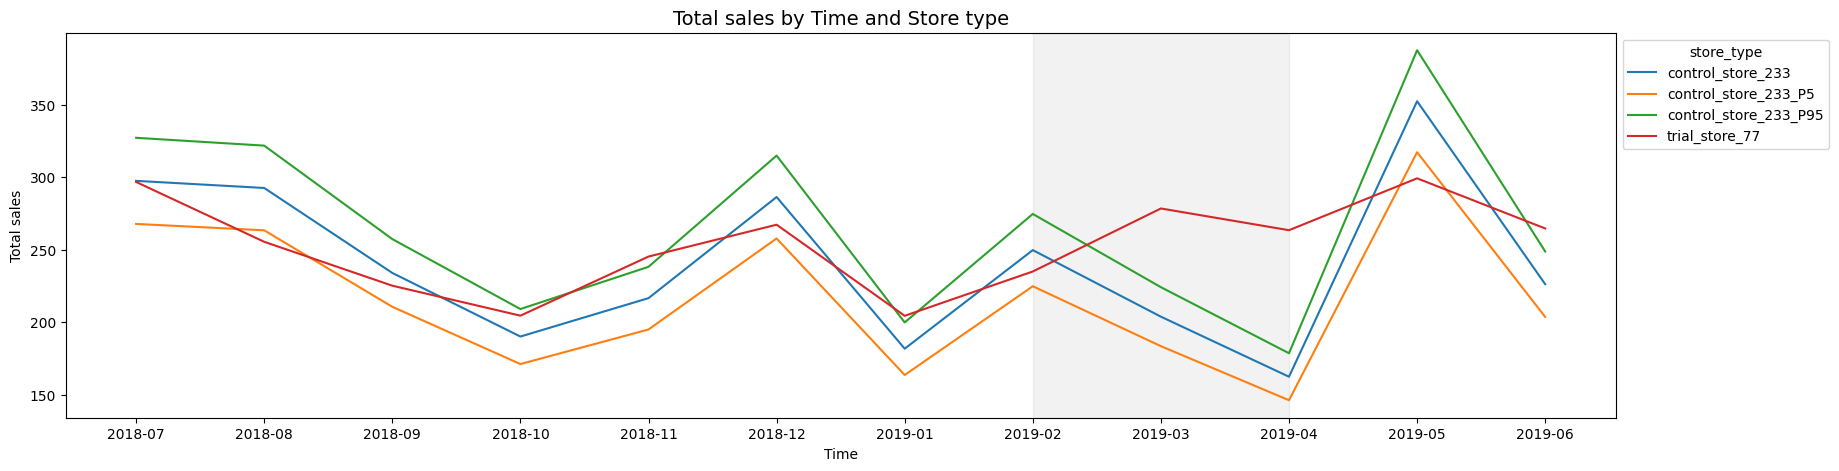

In [55]:
# Compute control store metrics and confidence intervals
tot_sales_confidence_intervals_77 = evaluate_confidence_intervals(tot_sales_pct_diff_77, start_trial_period, alpha, 'tot_sales', tot_sales_std_dev_77)

viz_trial_assess(tot_sales_confidence_intervals_77, 'tot_sales', 'Total sales', start_trial_period, end_trial_period)

The trial in store 77 is significantly different to its
control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial
months.

### No of customers

In [63]:
num_customers_pct_diff_77 = calc_percentage_difference(scaled_measures_over_time,  77, '#customers')
num_customers_pct_diff_77

,YEARMONTH,trial_store_77,control_store_233,pct_diff
0,201807,51.0,51.171141,0.003344
1,201808,47.0,48.161074,0.024108
2,201809,42.0,42.140940,0.003344
3,201810,37.0,35.117450,0.053607
4,201811,41.0,40.134228,0.021572
5,201812,46.0,47.157718,0.024550
6,201901,35.0,35.117450,0.003344
7,201902,45.0,45.151007,0.003344
8,201903,50.0,40.134228,0.245819
9,201904,47.0,30.100671,0.561427


In [61]:
# Compute std, t-value of each trial month and make h0 decision
num_customers_trial_assestment_77, num_customers_std_dev_77 = evaluate_t_values(num_customers_pct_diff_77, alpha, start_trial_period, end_trial_period)

num_customers_trial_assestment_77

,YEARMONTH,t_value,h0_decision
0,201902,0.183352,Accept H0
1,201903,13.476388,Reject H0
2,201904,30.778725,Reject H0


There are significant differences between trial and control stores' #customers in Mar and Apr.

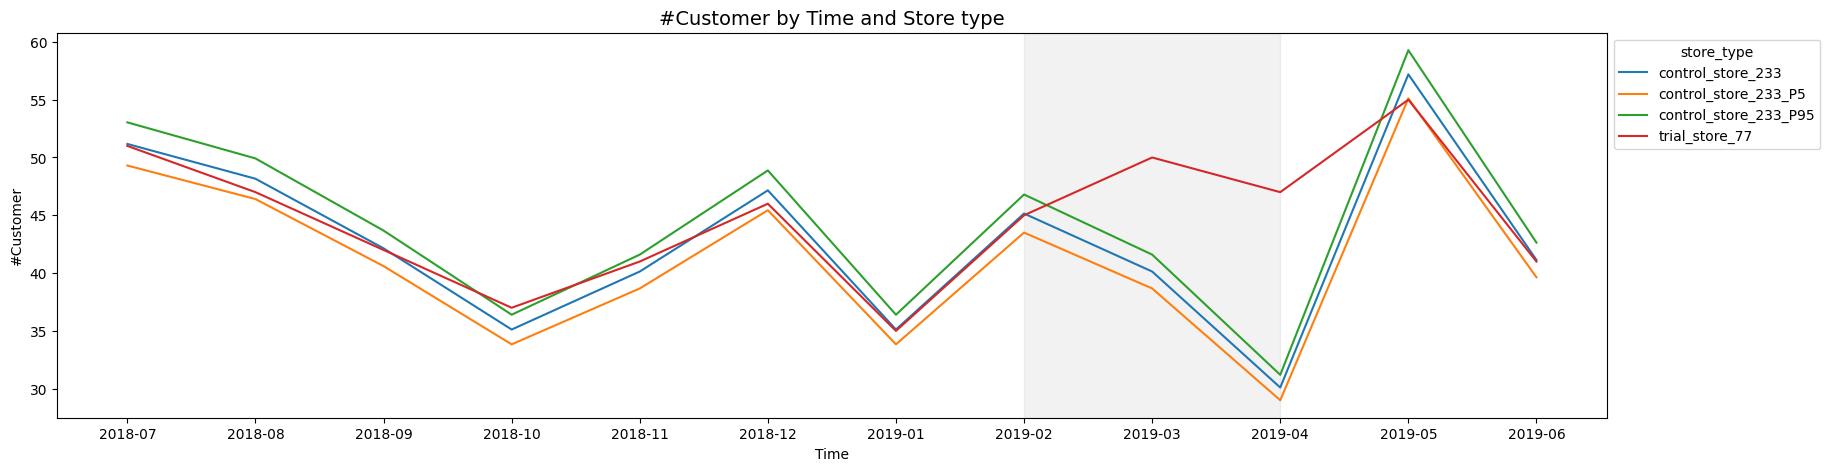

In [64]:
# Compute control store metrics and confidence intervals
num_customers_confidence_intervals_77 = evaluate_confidence_intervals(num_customers_pct_diff_77, start_trial_period, alpha, '#customers', num_customers_std_dev_77)

viz_trial_assess(num_customers_confidence_intervals_77, '#customers', '#Customer', start_trial_period, end_trial_period)

Total customers in trial store 77 is significantly different to its control store in the trial period. The trial store performance lies outside the 5% and 95% confidence intervals in two of three months trial period.

## Store 86

### Total sales

In [65]:
tot_sales_pct_diff_86 = calc_percentage_difference(scaled_measures_over_time,  86, 'tot_sales')
tot_sales_pct_diff_86

,YEARMONTH,trial_store_86,control_store_155,pct_diff
0,201807,892.20,896.922236,0.005265
1,201808,764.05,759.269991,0.006296
2,201809,914.60,984.034086,0.070561
3,201810,948.40,934.948790,0.014387
4,201811,918.00,871.894555,0.052880
5,201812,841.20,824.361363,0.020426
6,201901,841.40,848.418979,0.008273
7,201902,913.20,864.522060,0.056306
8,201903,1026.80,780.320405,0.315870
9,201904,848.20,819.317024,0.035253


In [66]:
# Compute std, t-value of each trial month and make h0 decision
tot_sales_trial_assestment_86, tot_sales_std_dev_86 = evaluate_t_values(tot_sales_pct_diff_86, alpha, start_trial_period, end_trial_period)

tot_sales_trial_assestment_86

,YEARMONTH,t_value,h0_decision
0,201902,2.179542,Reject H0
1,201903,12.226922,Reject H0
2,201904,1.364580,Accept H0


There is a difference between trial and control stores total sales in Feb and Mar.

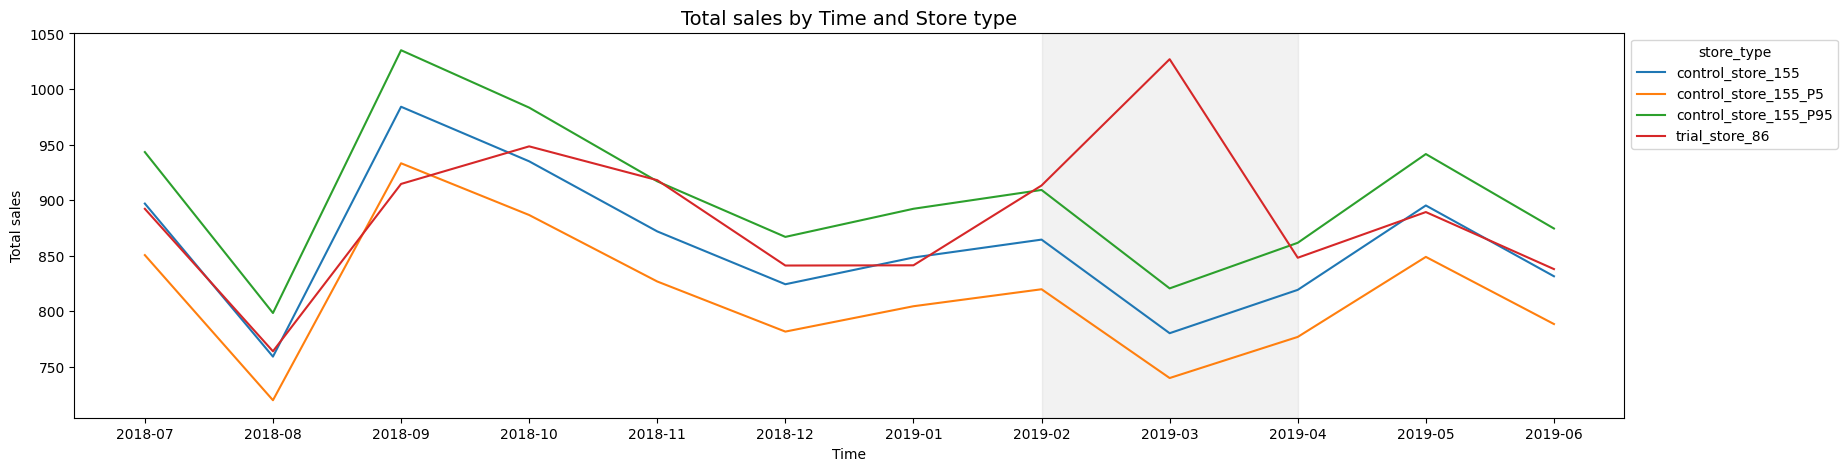

In [67]:
# Compute control store metrics and confidence intervals
tot_sales_confidence_intervals_86 = evaluate_confidence_intervals(tot_sales_pct_diff_86, start_trial_period, alpha, 'tot_sales', tot_sales_std_dev_86)

viz_trial_assess(tot_sales_confidence_intervals_86, 'tot_sales', 'Total sales', start_trial_period, end_trial_period)

Look like Feb total sales of the trial store 86 higher a bit than its control store 95% CI &rarr; Check number data again.

In [68]:
tot_sales_confidence_intervals_86[tot_sales_confidence_intervals_86['YEARMONTH'] >= '2019-02']

,YEARMONTH,control_store_155,control_store_155_P5,control_store_155_P95,trial_store_86
7,2019-02,864.522060,819.854016,909.190104,913.2
8,2019-03,780.320405,740.002884,820.637926,1026.8
9,2019-04,819.317024,776.984629,861.649419,848.2
10,2019-05,895.224622,848.970241,941.479003,889.3
11,2019-06,831.539845,788.575923,874.503767,838.0


The trial in store 86 is significantly different to its control store in the trial period as the trial store total sales lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

However, the trial store's sales for Feb are only slightly higher than the upper bound of the control store's 95% CI &rarr; While the sales are higher than expected under H0, the deviation is not very large &rarr; A higher risk of a false positive, meaning there might be a chance that the rejection of H0 is due to random variation rather than a true underlying effect.

### No of customers

In [69]:
num_customers_pct_diff_86 = calc_percentage_difference(scaled_measures_over_time,  86, '#customers')
num_customers_pct_diff_86

,YEARMONTH,trial_store_86,control_store_155,pct_diff
0,201807,99.0,101.0,0.019802
1,201808,94.0,91.0,0.032967
2,201809,103.0,103.0,0.000000
3,201810,109.0,108.0,0.009259
4,201811,100.0,101.0,0.009901
5,201812,98.0,97.0,0.010309
6,201901,94.0,96.0,0.020833
7,201902,107.0,95.0,0.126316
8,201903,115.0,94.0,0.223404
9,201904,105.0,99.0,0.060606


In [70]:
# Compute std, t-value of each trial month and make h0 decision
num_customers_trial_assestment_86, num_customers_std_dev_86 = evaluate_t_values(num_customers_pct_diff_86, alpha, start_trial_period, end_trial_period)

num_customers_trial_assestment_86

,YEARMONTH,t_value,h0_decision
0,201902,11.819082,Reject H0
1,201903,20.903430,Reject H0
2,201904,5.670772,Reject H0


There is a difference between trial and control stores number of customers in each month during trial period.

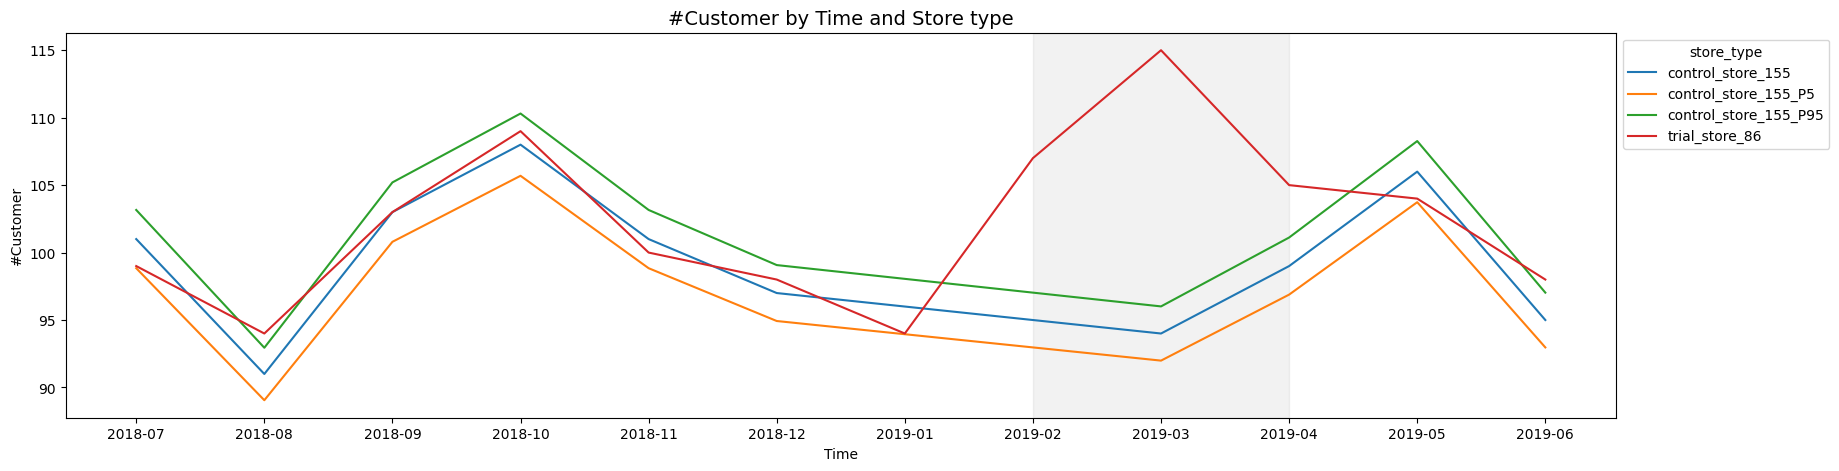

In [72]:
# Compute control store metrics and confidence intervals
num_customers_confidence_intervals_86 = evaluate_confidence_intervals(num_customers_pct_diff_86, start_trial_period, alpha, '#customers', num_customers_std_dev_86)

viz_trial_assess(num_customers_confidence_intervals_86, '#customers', '#Customer', start_trial_period, end_trial_period)

Number of customers of trial store is significantly higher than its control store in three months &rarr; Trial had a significant impact on increasing
the number of customers in trial store 86.

## Store 88

### Total sales

In [73]:
tot_sales_pct_diff_88 = calc_percentage_difference(scaled_measures_over_time,  88, 'tot_sales')
tot_sales_pct_diff_88

,YEARMONTH,trial_store_88,control_store_237,pct_diff
0,201807,1310.00,1450.657086,0.096961
1,201808,1323.80,1369.931485,0.033674
2,201809,1423.00,1324.260425,0.074562
3,201810,1352.40,1350.401097,0.001480
4,201811,1382.80,1399.777923,0.012129
5,201812,1325.20,1266.971288,0.045959
6,201901,1266.40,1221.600696,0.036673
7,201902,1370.20,1406.989143,0.026147
8,201903,1477.20,1210.082775,0.220743
9,201904,1439.40,1206.477165,0.193060


In [74]:
# Compute std, t-value of each trial month and make h0 decision
tot_sales_trial_assestment_88, tot_sales_std_dev_88 = evaluate_t_values(tot_sales_pct_diff_88, alpha, start_trial_period, end_trial_period)

tot_sales_trial_assestment_88

,YEARMONTH,t_value,h0_decision
0,201902,0.781270,Accept H0
1,201903,6.595668,Reject H0
2,201904,5.768527,Reject H0


There is a difference between trial and control stores total sales in Mar and Apr.

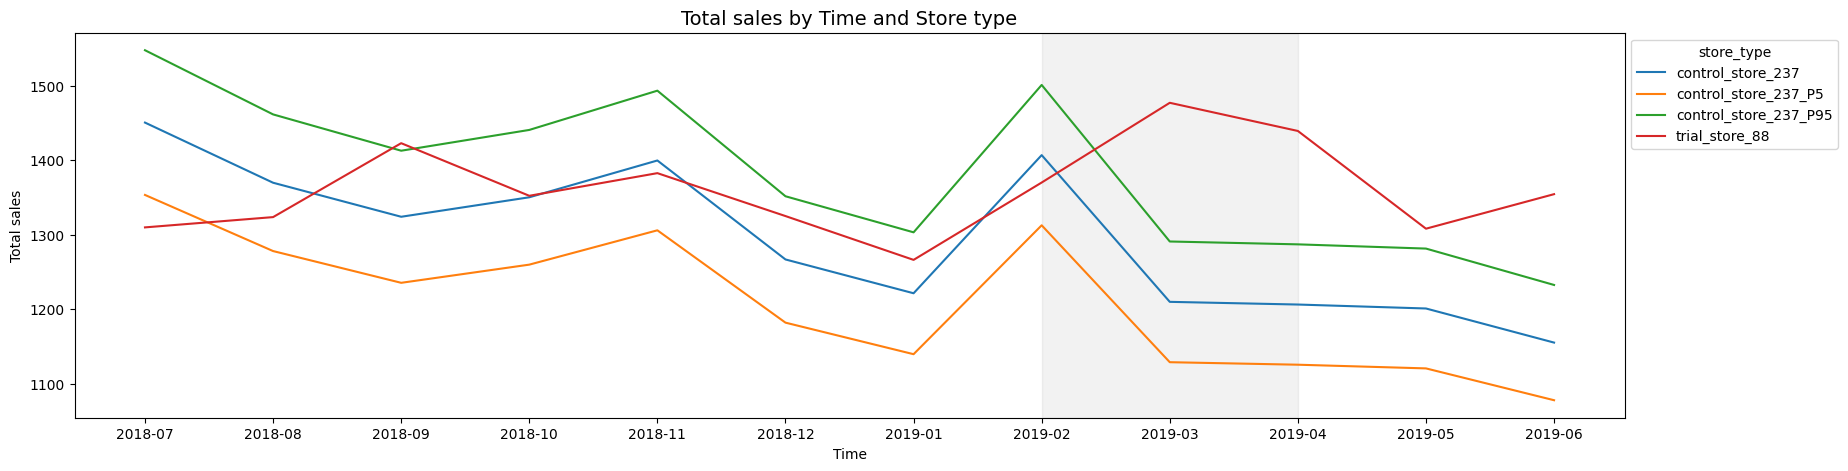

In [75]:
# Compute control store metrics and confidence intervals
tot_sales_confidence_intervals_88 = evaluate_confidence_intervals(tot_sales_pct_diff_88, start_trial_period, alpha, 'tot_sales', tot_sales_std_dev_88)

viz_trial_assess(tot_sales_confidence_intervals_88, 'tot_sales', 'Total sales', start_trial_period, end_trial_period)

The results show that the trial in store 88 is significantly different to its
control store in the trial period as the trial store performance lies outside of
the 5% to 95% confidence interval of the control store in two of the three trial
months.

### No of customers

In [76]:
num_customers_pct_diff_88 = calc_percentage_difference(scaled_measures_over_time,  88, '#customers')
num_customers_pct_diff_88

,YEARMONTH,trial_store_88,control_store_237,pct_diff
0,201807,129.0,127.276836,0.013539
1,201808,131.0,134.237288,0.024116
2,201809,124.0,125.288136,0.010281
3,201810,123.0,122.305085,0.005682
4,201811,130.0,131.254237,0.009556
5,201812,126.0,123.299435,0.021902
6,201901,117.0,116.338983,0.005682
7,201902,124.0,125.288136,0.010281
8,201903,134.0,118.327684,0.132448
9,201904,128.0,119.322034,0.072727


In [77]:
# Compute std, t-value of each trial month and make h0 decision
num_customers_trial_assestment_88, num_customers_std_dev_88 = evaluate_t_values(num_customers_pct_diff_88, alpha, start_trial_period, end_trial_period)

num_customers_trial_assestment_88

,YEARMONTH,t_value,h0_decision
0,201902,1.387456,Accept H0
1,201903,17.873693,Reject H0
2,201904,9.814423,Reject H0


There is a difference between trial and control stores number of customers in Mar and Apr.

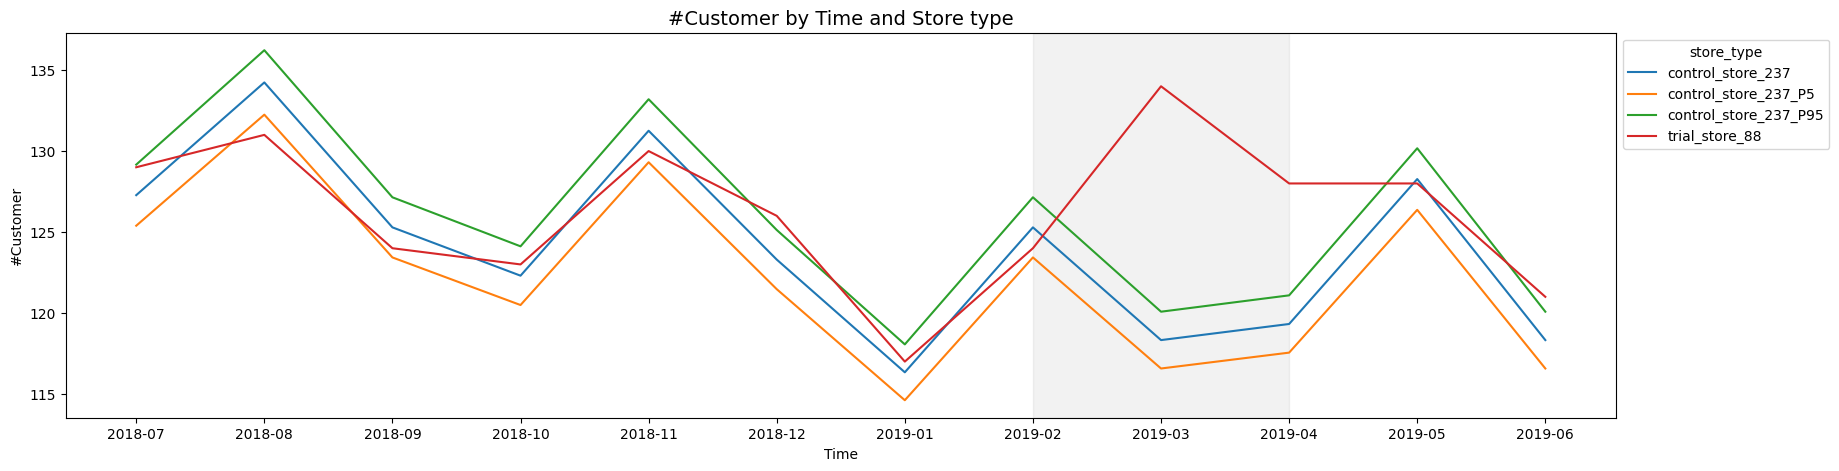

In [78]:
# Compute control store metrics and confidence intervals
num_customers_confidence_intervals_88 = evaluate_confidence_intervals(num_customers_pct_diff_88, start_trial_period, alpha, '#customers', num_customers_std_dev_88)

viz_trial_assess(num_customers_confidence_intervals_88, '#customers', '#Customer', start_trial_period, end_trial_period)

Total number of customers in the trial period for the trial store is significantly higher than the control store for two out of three months, which indicates a positive trial effect.

# Conclusion
* We've found control stores 233, 155, 237 for trial stores 77, 86 and 88
respectively.
* Store 77 and Store 88 showed significant improvements in sales and customer numbers from March onwards.
* Store 86 showed a significant increase in both sales and customer numbers in February and March, indicating a successful trial during these months. However, the slight deviation of February's sales suggests caution &rarr; We suggest to further analysis to ensure robust conclusions. Additionally, April had a significant increase in customers but not in sales &rarr; The trial had a significant impact on increasing the number of customers in trial store 86 but as we saw, overall sales were not significantly higher. We should check with the Category Manager if there were special deals in the trial store that were may have resulted in lower prices, impacting the results.
* For all stores, analyze the successful periods *(March and April for Stores 77 and 88, February and March for Store 86)* to identify the specific drivers of success. Apply these insights to other stores and consider extending the trial periods to ensure the sustainability of the observed improvements.
